First we have to set up the requirements

In [138]:
pip install -r "requirements.txt"

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [139]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import IPython.display as display
from scipy.optimize import newton
from matplotlib import cm

Let's consider the three body problem with gravitational forces present

#### a)

First let's do the calculations for $x$
\begin{align*}
    \ddot{x} = 2\omega\dot{y} + \omega^2 x - \frac{a^3\omega^2(1-\mu)(x+\mu a)}{s_1^3}-\frac{a^3\omega^2 \mu (x-a + \mu a)}{s_2^3}\\
    a\omega^2 \ddot{x'} = 2a\omega^2 \dot{y'} + a\omega^2 x' - \frac{a^3\omega^2(1-\mu)(ax'+\mu a)}{a^3s_1'^3}-\frac{a^3\omega^2 \mu (ax'-a + \mu a)}{a^3s_2'^3}\\
    \ddot{x'} = 2\dot{y'} + x - \frac{(1-\mu)(x'+\mu)}{s_1'^3}-\frac{\mu (x'-1 + \mu)}{s_2'^3}
\end{align*}
Now for $y$
\begin{align*}
    \ddot{y} = -2\omega\dot{x} + \omega^2 y - \frac{a^3\omega^2(1-\mu)y}{s_1^3}-\frac{a^3\omega^2 \mu y}{s_2^3}\\
    a\omega^2 \ddot{y'} = -2a\omega^2 \dot{x'} + a\omega^2 y' - \frac{a^3\omega^2(1-\mu)ay'}{a^3s_1'^3}-\frac{a^3\omega^2 \mu a y'}{a^3s_2'^3}\\
    \ddot{y'} = -2\dot{x'} + y' - \frac{(1-\mu)y'}{s_1'^3}-\frac{\mu y'}{s_2'^3}
\end{align*}
And now $z$
\begin{align*}
    \ddot{z} = -\frac{a^3\omega^2(1-\mu)z}{s_1^3}-\frac{a^3\omega^2\mu z}{s_2^3}\\
    a\omega^2 \ddot{z'} = -\frac{a^4\omega^2(1-\mu)z'}{a^3s_1'^3}-\frac{a^4\omega^2\mu z'}{a^3s_2'^3}\\
    \ddot{z'} = -\frac{(1-\mu)z'}{s_1'^3}-\frac{\mu z'}{s_2'^3}
\end{align*}

Here I have used the fact that $s_1'$ and $s_2'$ is defined such that they obey the same transformation as $x, y$ and $z$, namely $s_i = a s_i'$

#### b)

From now on $x'$ will be denoted as $x$ and the same for $y',z'$ and the $s_i'$

$x'$ now denotes the first time derivative of $x$, making this the new variable, giving us our first order differential equations

\begin{align*}
    \dot{x}  &= x'\\
    \dot{x'} &= 2y' + x - \frac{(1-\mu)(x+\mu)}{s_1^3}-\frac{\mu (x-1 + \mu)}{s_2^3}\\\\
    \dot{y}  &= y'\\
    \dot{y'} &= -2x' + y - \frac{(1-\mu)y}{s_1^3}-\frac{\mu y}{s_2^3}\\\\
    \dot{z}   &= z'\\
    \dot{z'} &= -\frac{(1-\mu)z}{s_1^3}-\frac{\mu z}{s_2^3}\\\\
\end{align*}

To recap, our variables are now $x,y,z,x',y',z'$

In [140]:
class System:
    def __init__(self, mu):
        self.mu = mu
        self.R = np.zeros((3,3))
        self.R[2,2] = 1
        self.L2 = newton(self.dU, x0 = 1,   tol = 10**(-10), maxiter = 200)
        self.L1 = newton(self.dU, x0 = 0,   tol = 10**(-10), maxiter = 200)
        self.L3 = newton(self.dU, x0 = -1,  tol = 10**(-10), maxiter = 200)

    def s_1(self, x,y,z):
        self.s1 = np.sqrt((x+self.mu)**2 + y**2 + z**2)

    def s_2(self, x, y, z):
        self.s2 = np.sqrt((x-1+self.mu)**2 + y**2 + z**2)
    
    def xdot(self, params):
        return params[3]
    
    def ydot(self, params):
        return params[4]
    
    def zdot(self, params):
        return params[5]
    
    def xddot(self, params):
        return 2*params[4] + params[0] - (1-self.mu)*(params[0] + self.mu)/self.s1**3 - self.mu*(params[0]-1+self.mu)/self.s2**3

    def yddot(self, params):
        return -2*params[3] + params[1] - (1-self.mu)*params[1]/self.s1**3 - self.mu*params[1]/self.s2**3
    
    def zddot(self, params):
        return - (1-self.mu)*params[2]/self.s1**3 - self.mu*params[2]/self.s2**3

    def function(self, t, params):
        self.s_1(params[0], params[1], params[2])
        self.s_2(params[0], params[1], params[2])
        return np.array([self.xdot(params), self.ydot(params), self.zdot(params), self.xddot(params), self.yddot(params), self.zddot(params)])

    def solve(self, dt, T, initial, method = 'DOP853'):
        self.q0 = initial
        self.t = np.arange(0,T,dt)
        self.dt = dt
        self.T = T
        self.solution = solve_ivp(fun = self.function, t_span = (0, T), y0 = self.q0, method = method, t_eval=self.t)
        self.pos = self.solution["y"][0:3]
        self.vel = self.solution["y"][3:6]

    def plot(self):
        fig, ax = plt.subplots()

        ax.plot(self.pos[0], self.pos[1])
        ax.scatter([-self.mu, 1-self.mu], [0,0])
        ax.set_aspect("equal")

        plt.show()
    
    def set_R(self, t):
        self.R[0,0] = np.cos(t)
        self.R[0,1] = -np.sin(t)
        self.R[1,0] = np.sin(t)
        self.R[1,1] = np.cos(t)

    def inertial(self):
        self.inertial_pos = np.zeros((3, len(self.t)))
        self.inertial_vel = np.zeros_like(self.inertial_pos)
        self.inertial_pos_m1 = np.zeros_like(self.inertial_pos)
        self.inertial_pos_m2 = np.zeros_like(self.inertial_pos)

        m1 = np.array([-self.mu, 0,0])
        m2 = np.array([1-self.mu, 0,0])

        for t_i in range(len(self.t)):
            self.set_R(self.t[t_i])

            self.inertial_pos[:,t_i] = self.R @ self.pos[:,t_i]
            self.inertial_vel[:,t_i] = self.R @ self.vel[:,t_i]
            self.inertial_vel[:,t_i] += self.R @ (np.array([-self.pos[1,t_i],self.pos[0,t_i],0]))

            self.inertial_pos_m1[:,t_i] = self.R @ m1
            self.inertial_pos_m2[:,t_i] = self.R @ m2

    def plot_inertial(self):

        self.inertial()

        fig, ax = plt.subplots()

        ax.plot(self.inertial_pos[0], self.inertial_pos[1])
        ax.plot(self.inertial_pos_m1[0], self.inertial_pos_m1[1])
        ax.plot(self.inertial_pos_m2[0], self.inertial_pos_m2[1])
        ax.set_aspect("equal")

        plt.show()

    def jacobi(self):
        
        self.C = -np.linalg.norm(self.vel, axis = 0)**2 + np.linalg.norm(self.pos[:2,:], axis = 0)**2
        
        for t_i in range(np.size(self.t)):
            self.s_1(self.pos[0,t_i], self.pos[1,t_i], self.pos[2,t_i])
            self.s_2(self.pos[0,t_i], self.pos[1,t_i], self.pos[2,t_i])
            self.C[t_i] += 2*(1-self.mu)/self.s1
            self.C[t_i] += 2*self.mu/self.s2

        self.C += self.mu*(1-self.mu)

    def plot_jacobi(self):

        self.jacobi()

        plt.plot(self.t, self.C)
        plt.ticklabel_format(style='plain', useOffset=False)
        plt.show()

    def inertial_video(self, T = 0, start_T = 0):

        self.inertial()

        if (T == 0 or T > self.T):
            T = self.T

        if (T+start_T) > self.T:
            start_T = self.T-T

        fig, ax = plt.subplots(figsize=(10,10))

        ax.set_title(label = "Rotating Frame")

        ax.set_xlim(1.1*np.min(self.inertial_pos[0,:]) if np.min(self.inertial_pos[0,:]) < -1 else -1.1, 1.1*np.max(self.inertial_pos[0,:]) if np.max(self.inertial_pos[0,:]) > 1 else 1.1)
        ax.set_ylim(1.1*np.min(self.inertial_pos[1,:]) if np.min(self.inertial_pos[1,:]) < -1 else -1.1, 1.1*np.max(self.inertial_pos[1,:]) if np.max(self.inertial_pos[1,:]) > 1 else 1.1)

        points = ax.scatter([],[], color='blue')

        def _drawframe(x):

            points.set_offsets([self.inertial_pos[:2,int(start_T/self.dt) + x*int(0.01/self.dt)], self.inertial_pos_m1[:2,int(start_T/self.dt) + x*int(0.01/self.dt)], self.inertial_pos_m2[:2,int(start_T/self.dt) + x*int(0.01/self.dt)]])

            return [points]

        anim = animation.FuncAnimation(fig, _drawframe, frames=int(100*T), interval=10, blit=True)
        video = HTML(anim.to_html5_video())
        display.display(video)
        plt.close()

    def video(self, T = 0, start_T = 0):

        if (T == 0 or T > self.T):
            T = self.T

        if (T+start_T) > self.T:
            start_T = self.T-T

        fig, ax = plt.subplots(figsize=(10,10))

        ax.set_title(label = "Rotating Frame")

        ax.set_xlim(1.1*np.min(self.pos[0,:]) if np.min(self.pos[0,:]) < -self.mu else -1.1, 1.1*np.max(self.pos[0,:]) if np.max(self.pos[0,:]) > 1-self.mu else 1.1)
        ax.set_ylim(1.1*np.min(self.pos[1,:]), 1.1*np.max(self.pos[1,:]))

        points = ax.scatter([],[], color='blue')

        def _drawframe(x):

            points.set_offsets([self.pos[:2,int(start_T/self.dt) + x*int(0.01/self.dt)], [-self.mu, 0], [1-self.mu, 0]])

            return [points]

        anim = animation.FuncAnimation(fig, _drawframe, frames=int(100*T), interval=10, blit=True)
        video = HTML(anim.to_html5_video())
        display.display(video)
        plt.close()

    def U(self, x,y = 0):

        return -1/2*(x**2+y**2)-(1-self.mu)/np.sqrt((x+self.mu)**2+y**2)-self.mu/np.sqrt((x-1+self.mu)**2+y**2)-1/2*self.mu*(1-self.mu)
    
    def dU(self, x):
        term1 = -x
        term2 = (1 - self.mu) / (x + self.mu)**2
        term3 = self.mu / (x - 1 + self.mu)**2
        if x > 1-self.mu:
            return term1 + term2 + term3
        if x > -self.mu:
            return term1 + term2 - term3
        else:
            return  term1 - term2 - term3
    
    def plot_contour(self):
        x = np.linspace(-1.5,2,50)
        y = np.linspace(-1.75, 1.75,50)
        xv,yv = np.meshgrid(x, y)
        
        fig, ax = plt.subplots()

        ax.set_xlim(-1.5,2)
        ax.set_ylim(-1.75,1.75)
        ax.contour(xv,yv, self.U(xv,yv), levels = 400)
        ax.scatter([-self.mu, 1-self.mu], [0,0], s = 2, marker = "o")
        ax.scatter([self.L1, self.L2, self.L3], [0,0,0], marker = "x")
        
        ax.set_aspect("equal")
        plt.show()
    
    def plot_stability(self, num, d = 0.1):
        if num == 1:
            point = self.L1
        elif num == 2:
            point = self.L2
        elif num == 3:
            point = self.L3
        else:
            print("Wrong Number")
            return None
        
        x = np.linspace(-d + point, point + d, 20)
        y = np.linspace(-d, d, 20)
        xv,yv = np.meshgrid(x, y)
        
        fig, ax = plt.subplots()

        U = self.U(xv, yv)
        G = np.gradient(U)

        ax.set_xlim(-d + point, point + d)
        ax.set_ylim(-d, d)
        ax.scatter([point],[0], marker="x", color = "red")
        ax.streamplot(xv, yv, G[1], G[0], broken_streamlines = True)
        plt.show()

    def plot_stability_height(self, num, d = 0.1):
        if num == 1:
            point = self.L1
        elif num == 2:
            point = self.L2
        elif num == 3:
            point = self.L3
        else:
            print("Wrong Number")
            return None

        x = np.linspace(-d, d, 21)
        y = np.linspace(-d, d, 21)
        xv,yv = np.meshgrid(x, y)

        fig = plt.figure()
        ax = fig.add_subplot(projection = '3d')

        U = self.U(xv+point, yv)

        pos = np.array([xv,yv])
        pos = np.swapaxes(pos, 0,-1)

        def new_coords(theta):
            c, s = np.cos(theta), np.sin(theta)
            R = np.array(((c, -s), (s, c)), dtype = float)
            return np.einsum('ij,klj->kli', R, pos)

        def _drawframe(x):
            ax.cla()
            ax.set_xlim(-np.sqrt(2)*d,np.sqrt(2)*d)
            ax.set_ylim(-np.sqrt(2)*d,np.sqrt(2)*d)
            points1 = ax.scatter([0],[0],[0], marker="o", color = "blue")
            ax.set_xticks([])
            ax.set_yticks([])
            points2 = ax.contour3D(new_coords(2*np.pi*float(x)/100)[:,:,0], new_coords(2*np.pi*float(x)/100)[:,:,1], U-self.U(point,0), 100, cmap = cm.coolwarm)
            return [points1, points2]

        anim = animation.FuncAnimation(fig, _drawframe, frames=100, interval=50, blit=True)
        video = HTML(anim.to_html5_video())
        display.display(video)
        plt.close()
        

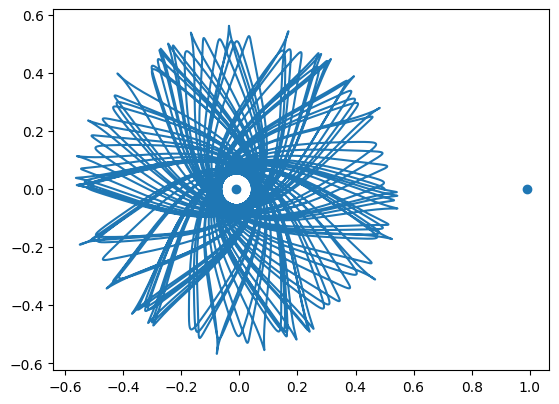

In [141]:
system = System(mu = 0.01)
system.solve(dt = 0.001, initial = [0.5,0,0,0,0.1,0], T = 100)
system.plot()

Now let's transform the system into the inertial frame. I do this in the `System.inertial` function, which I call upon in the `System.plot_inertial` function

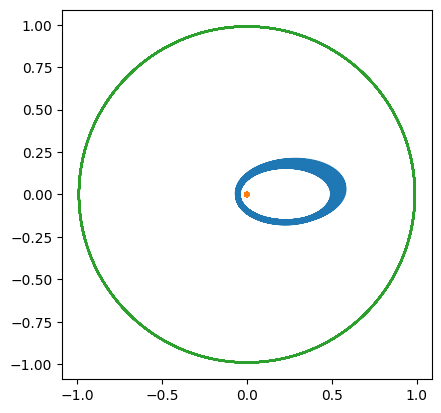

In [142]:
system.plot_inertial()

#### c)

As we can see, the three objects have three different orbits, and they seem quite stable. But seeing as the line isn't slim, we have quite some deviation. Let's take a look at the energy, and then a video of this plot, but where we follow the objects in "real" time

The `System.jacobi` function calculates the jacobian, which should be a constant of motion, and is called upon in `System.plot_jacobi`, where we plot the constant over time, and check if it's actually a constant

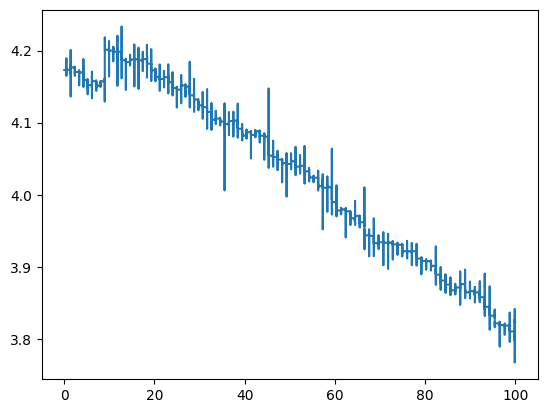

In [143]:
system.plot_jacobi()

As we can see, the constant isn't very constant, it's slowly decreasing over time, but since we have quite a big timestep we will allow it, and say that it's probably numerical errors, and not the fact that my method is wrong, but it might be. We can atleast conclude that our method isn't the best

Now let's animate a video for how the planets and objects move, both in the inertial frame and the rotating one, starting with rotating. The video takes a very long time to generate, so I simulate the motion again, just over a little less time, just to get a sense of how it looks, which also could be a great check to see if something is wrong with our method

In [144]:
system.solve(dt = 0.001, initial = [0.5,0,0,0,0.1,0], T = 20)
system.video()

Let's now do the inertial frame

In [145]:
system.inertial_video()

#### d)

\begin{align*}
    \tilde{U}(x,0) = -\frac{x^2}{2}-\frac{1-\mu}{|x+\mu|}-\frac{\mu}{|x-1+\mu|}-\frac{\mu(1-\mu)}{2}
\end{align*}
We can evaluate this in three different areas giving life to three different derivatives, each being applicable in their own regions
\begin{align*}
    \frac{\partial \tilde{U}}{\partial x} = \left\{\begin{array}{cc}
    -x + \frac{1-\mu}{(x+\mu)^2} + \frac{\mu}{(x-1+\mu)^2} & x > 1-\mu\\
    -x + \frac{1-\mu}{(x+\mu)^2} - \frac{\mu}{(x-1+\mu)^2} & 1-\mu > x > -\mu\\
    -x - \frac{1-\mu}{(x+\mu)^2} - \frac{\mu}{(x-1+\mu)^2} & -\mu > x\\
    \end{array}\right\}
\end{align*}
When we set these expressions equal to zero, we get 3 polynomials of degree 5, but they all have just one real solution, and that solution is in the correct x-area, so we get the three different points. Let's find the roots with Newton's method, simply because there won't be any nice analytical solution, and then it is easy to implement for many different $\mu$. Let's for example calculate the three points for $\mu=1.215\cdot 10^{-2}$, ergo the earth-moon system

In [146]:
system = System(mu = 1.215*10**(-2))
print("L1: ", system.L1)
print("L2: ", system.L2)
print("L3: ", system.L3)

L1:  0.8369180073169304
L2:  1.1556799130947353
L3:  -1.0050624018204988


Let's also try and plot heightlines and somewhat of a heatmap of the area, and the potential from the gravitational forces

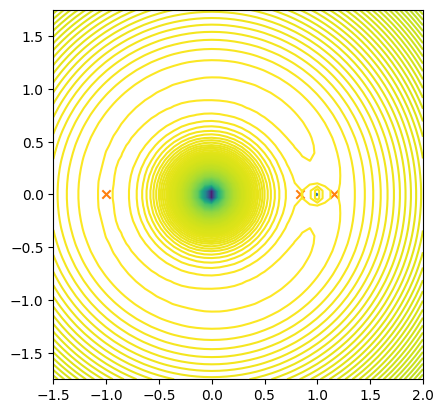

In [147]:
system.plot_contour()

#### Let's check out L1

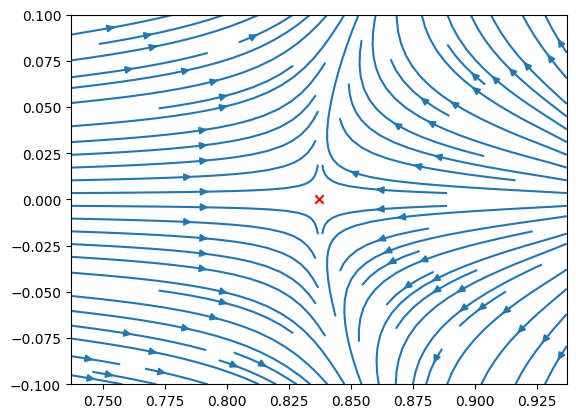

In [148]:
system.plot_stability(num = 1)
system.plot_stability_height(num = 1)

The first point shows the directions of the gradients! The second plot shows the potential around the fixed point, rotated to give a better visualization. As we can see we have a saddle point

#### Let's check out L2

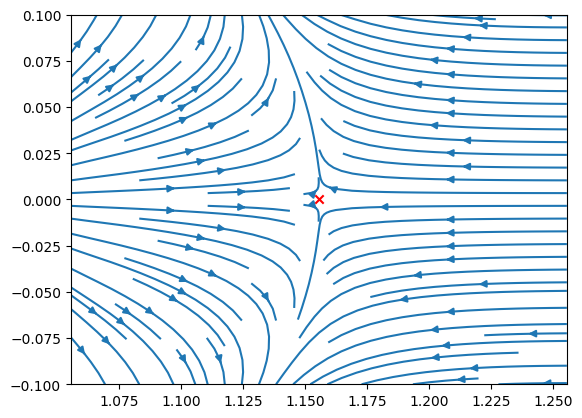

In [149]:
system.plot_stability(num = 2)
system.plot_stability_height(num = 2)

The first point shows the directions of the gradients! The second plot shows the potential around the fixed point, rotated to give a better visualization. As we can see, we have a saddle point

#### Let's check out L3

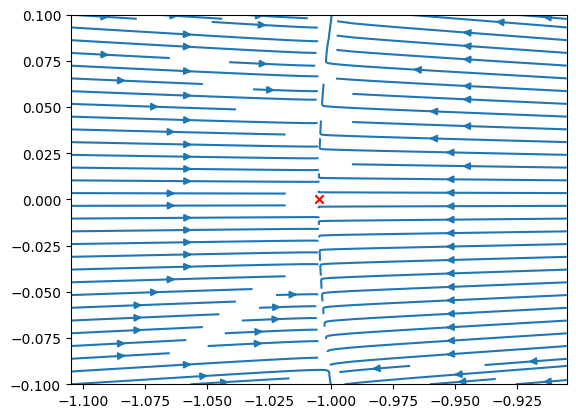

In [150]:
system.plot_stability(num = 3)
system.plot_stability_height(num = 3)

The first point shows the directions of the gradients! The second plot shows the potential around the fixed point, rotated to give a better visualization. As we can see, this fixed point still seems to be a saddle point, but the curvature is much steeper in the x direction than in the y direction, so it behaves much like a normal top-point

Let's place our object in the fixed point L1 and see what happens over time!

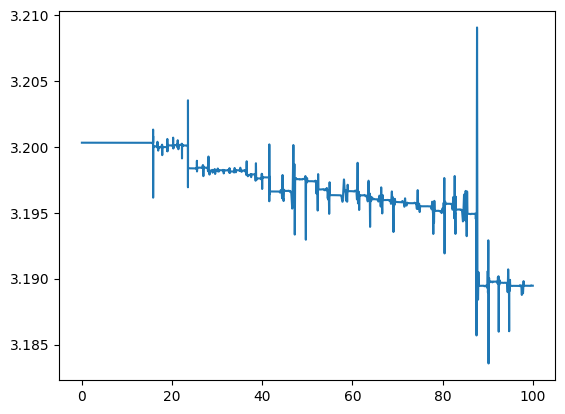

In [151]:
system = System(mu = 1.215*10**(-2))
system.solve(dt = 0.001, initial = [system.L1,0,0,0,0,0], T = 100)
system.plot_jacobi()

Here we see that the energy is very stable for quite some time, indicating that there might be little movement in this time-period

Now let's place the system just a little bit ($10^{-5}$) away from the fixed points, and see how that effects the simulation

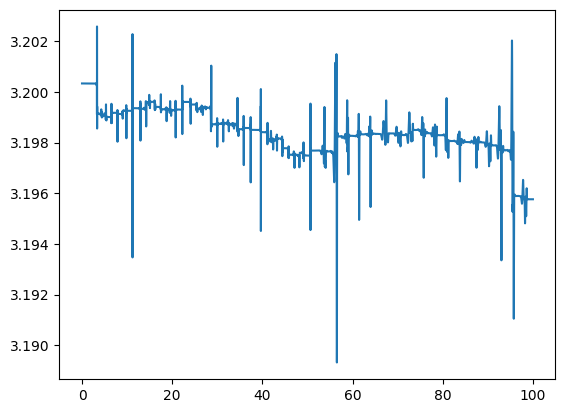

In [152]:
system.solve(dt = 0.001, initial = [system.L1+10**(-5),0,0,0,0,0], T = 100)
system.plot_jacobi()

As we can see this system is "fixed" for much less time than the first one. Here we see big jumps in energy very quickly, but when we placed the object in the fixed point it took much longer time before we saw energy jumps

To see how the objects move, let's see the video for this simulation, again testing to see if it's okay to lower the period

In [153]:
system.solve(dt = 0.001, initial = [system.L1,0,0,0,0,0], T = 30)
system.video()
system.inertial_video()

And let's also do it for the one a little bit off the fixed point

In [154]:
system.solve(dt = 0.001, initial = [system.L1+10**(-5),0,0,0,0,0], T = 10)
system.video()
system.inertial_video()

As we can see, this deviates from the fixed path much before the one on the stable point. This shows that small differences matter!

Further we can check which of the three fixed points is the most stable for the earth-moon system

L1


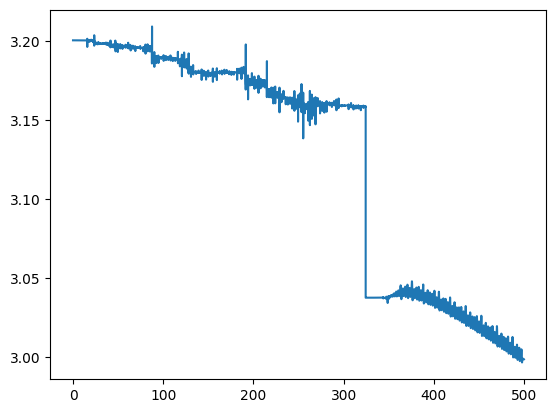

L2


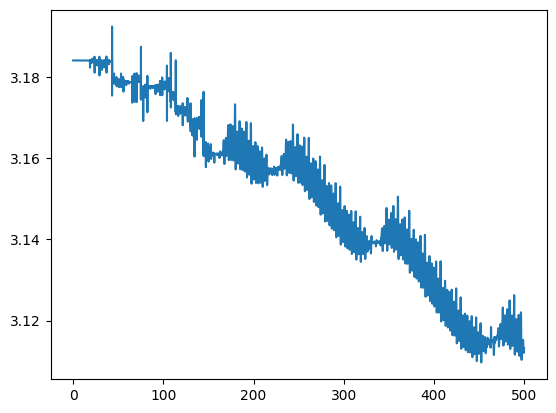

L3


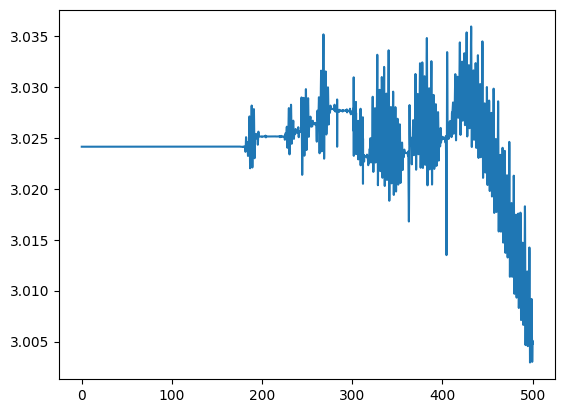

In [156]:
system = System(mu = 1.215*10**(-2))
system.solve(dt = 0.001, initial = [system.L1,0,0,0,0,0], T = 500)
print("L1")
system.plot_jacobi()
system.solve(dt = 0.001, initial = [system.L2,0,0,0,0,0], T = 500)
print("L2")
system.plot_jacobi()
system.solve(dt = 0.001, initial = [system.L3,0,0,0,0,0], T = 500)
print("L3")
system.plot_jacobi()

As we can see L3 seems the most stable! This makes sense cause if we look at the rotating plots of the potentials around the fixed point, the difference between the fixed point and the lowest point is much smaller for L3 than it is for L1 and L2